# Coronavirus (COVID-19) Visualization & Prediction  

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('seaborn-poster')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")

# read data

In [3]:
confirmed_df = pd.read_csv("covid19_confirmed_global.txt")
deaths_df = pd.read_csv("covid19_deaths_global.txt")

# only filter US data
cols = confirmed_df.keys()
confirmed = confirmed_df[confirmed_df["Country/Region"] == "US"].loc[:, cols[4]:cols[-1]]
deaths = deaths_df[deaths_df["Country/Region"] == "US"].loc[:, cols[4]:cols[-1]]

# get the dates
dates = confirmed.keys()

In [4]:
confirmed_df[confirmed_df["Country/Region"] == "US"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/20/21,11/21/21,11/22/21,11/23/21,11/24/21,11/25/21,11/26/21,11/27/21,11/28/21,11/29/21
255,NaN,US,40.0,-100.0,1,1,2,2,5,5,...,47700783,47738554,47889042,47981453,48092823,48125425,48176523,48201079,48229210,48437955


In [4]:
print(dates[0], dates[-1])

1/22/20 11/29/21


## Getting daily increases and moving averages

In [31]:
def compute_daily_statistic(data):
    daily_df = data.T.diff(periods=1)
    daily_df.columns = ["cnt"]
    daily_df.iloc[0, 0] = confirmed.iloc[0, 0]
    return daily_df

def moving_average(data, window_size):
    data = data.rolling(window_size).mean().fillna(0)
    return data

# window size: 1 week
window_size = 7

# confirmed cases
us_daily_confirm = compute_daily_statistic(confirmed)
us_daily_confirm_avg = moving_average(us_daily_confirm, window_size)

# deaths
us_daily_death = compute_daily_statistic(deaths)
us_daily_death_avg = moving_average(us_daily_death, window_size)

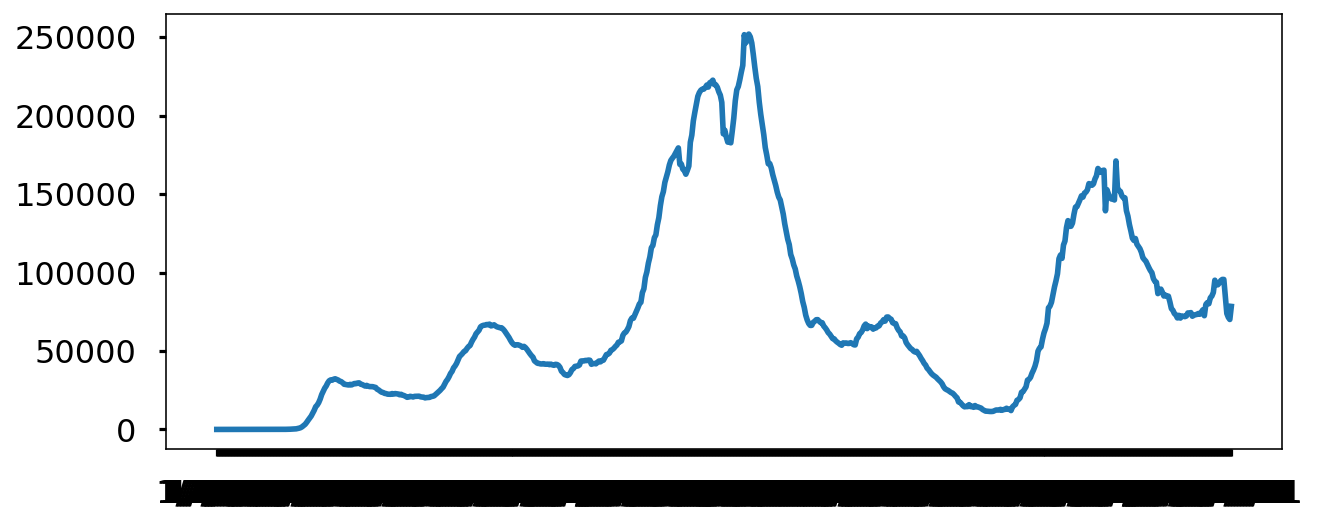

In [10]:
fig = plt.figure(figsize=(10,4))
plt.plot(us_daily_confirm_avg["cnt"])
plt.show()

In [12]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
us_daily_confirm = np.array(us_daily_confirm).reshape(-1, 1)
us_daily_death = np.array(us_daily_death).reshape(-1, 1)

## Future forcasting dates

In [140]:
days_in_future = 7
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[-7:]

In [142]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

## prepare train, test data

In [143]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(
    days_since_1_22, 
    confirmed.T.values, 
    test_size=0.1, shuffle=False
) 

## polynomial

In [183]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=2)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 2705775.19033023
MSE: 7829297959549.666


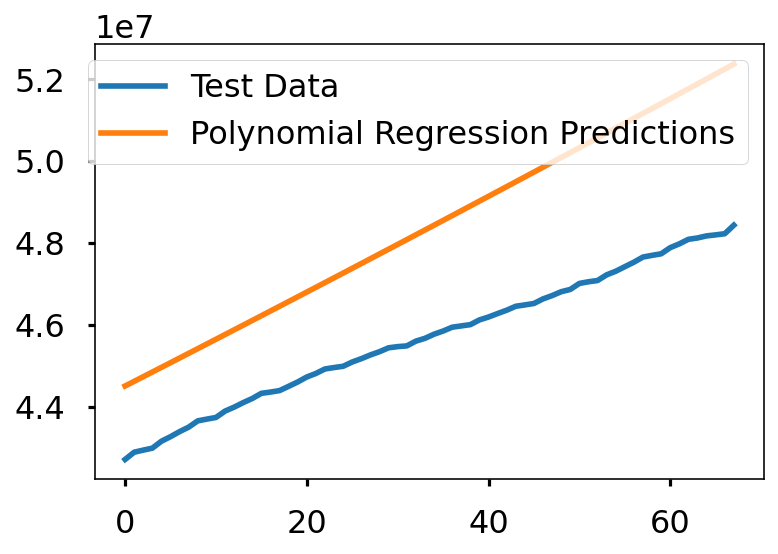

In [184]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [185]:
# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
normalize = [True, False]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2, 
                 'normalize' : normalize}

bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train_confirmed)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test_confirmed)
bayesian_poly_future_forcast = bayesian_poly.fit_transform(future_forcast)

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


RandomizedSearchCV(cv=3, estimator=BayesianRidge(fit_intercept=False),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'lambda_2': [1e-07, 1e-06, 1e-05,
                                                     0.0001, 0.001],
                                        'normalize': [True, False],
                                        'tol': [1e-06, 1e-05, 0.0001, 0.001,
                                                0.01]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [186]:
bayesian_search.best_params_

{'tol': 0.0001,
 'normalize': False,
 'lambda_2': 0.001,
 'lambda_1': 0.001,
 'alpha_2': 1e-06,
 'alpha_1': 1e-07}

In [187]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(bayesian_poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(bayesian_poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 4648939.628710158
MSE: 22806677180021.9


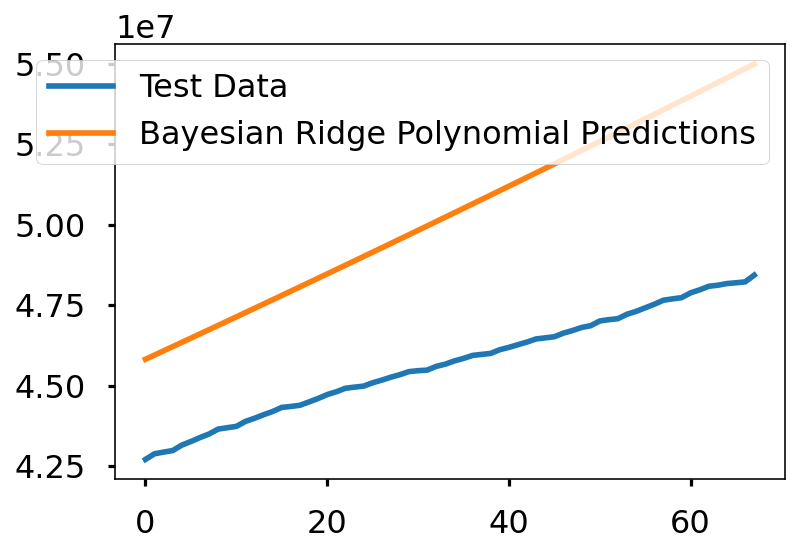

In [188]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

# Predictions for confirmed coronavirus cases worldwide
These three models predict future covid cases on a global level. 

The prediction models include 
* Support Vector Machine 
* Polynomial Regression 
* Bayesian Ridge Regression 

<a id='prediction'></a>

In [153]:
def plot_predictions(x, y, pred, algo_name, color):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y)
    plt.plot(x, pred, linestyle='dashed', color=color)
    plt.title('Worldwide Coronavirus Cases Over Time', size=10)
    plt.xlabel('Days Since 1/22/2020', size=10)
    plt.ylabel('# of Cases', size=10)
    plt.legend(['Confirmed Cases', algo_name], prop={'size': 10})
    plt.xticks(size=10)
    plt.yticks(size=10)
    plt.show()

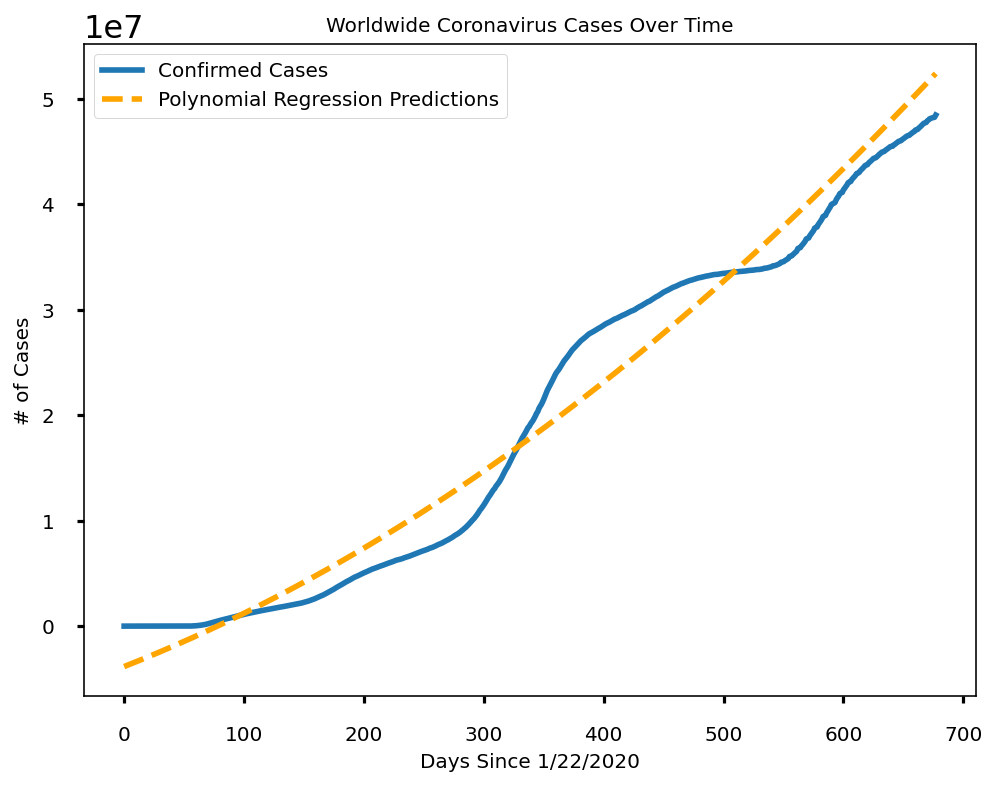

In [155]:
plot_predictions(future_forcast[:-7], confirmed.T.values, linear_pred[:-7], 'Polynomial Regression Predictions', 'orange')

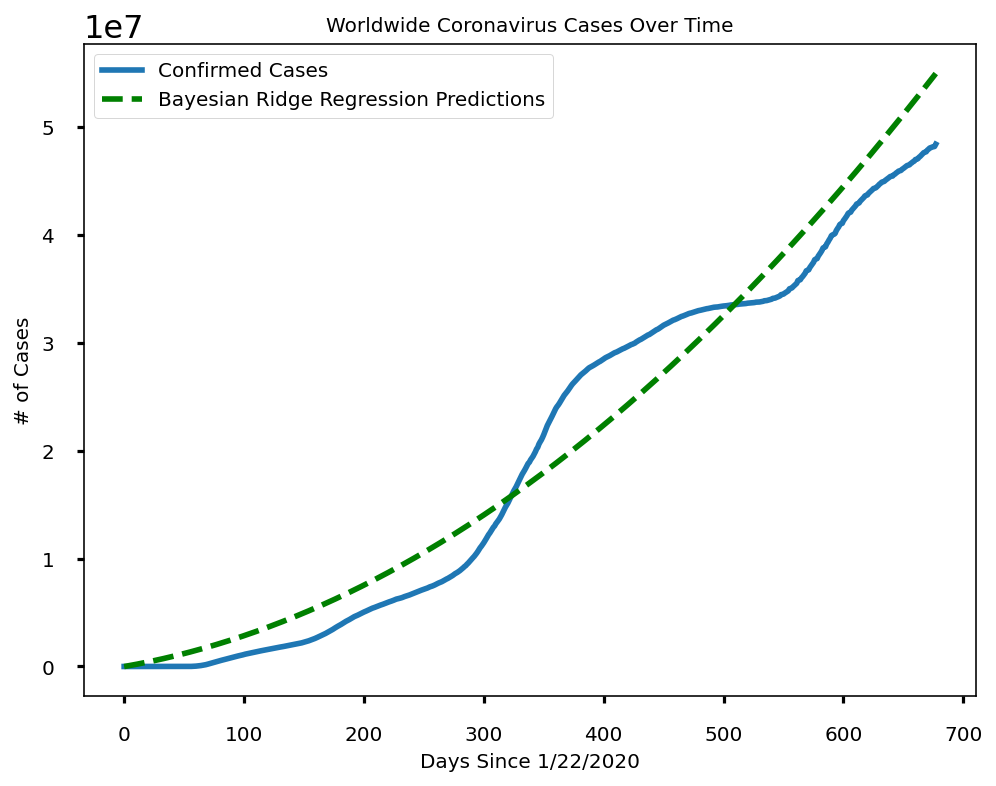

In [156]:
plot_predictions(future_forcast[:-7], confirmed.T.values, bayesian_pred[:-7], 'Bayesian Ridge Regression Predictions', 'green')

- daily new cases

In [213]:
def compute_daily_increase(future_forcast_dates, pred_df, name, n_days=8):
    pred_df = pred_df.reshape(1,-1)[0]
    pred_df = pd.DataFrame({
        'date': future_forcast_dates[-n_days:], 
        'cumulative_pred': np.round(pred_df[-n_days:])
    })
    pred_df[name] = pred_df["cumulative_pred"].diff(1)
    return pred_df.iloc[1:][["date", name]].set_index("date")

In [214]:
linear_df = compute_daily_increase(future_forcast_dates, linear_pred, "linear_pred", n_days=8)
bayesian_df =  compute_daily_increase(future_forcast_dates, bayesian_pred, "bayesian_pred", n_days=8)

In [215]:
bayesian_df

,bayesian_pred
date,
11/30/2021,143055.0
12/01/2021,143237.0
12/02/2021,143419.0
12/03/2021,143602.0
12/04/2021,143784.0
12/05/2021,143967.0
12/06/2021,144149.0


In [216]:
linear_df

,linear_pred
date,
11/30/2021,121250.0
12/01/2021,121363.0
12/02/2021,121476.0
12/03/2021,121588.0
12/04/2021,121702.0
12/05/2021,121814.0
12/06/2021,121926.0


In [222]:
final_pred = linear_df.join(bayesian_df, on="date")
final_pred["pred"] = (final_pred["linear_pred"] + final_pred["bayesian_pred"]) / 2

In [223]:
final_pred

,linear_pred,bayesian_pred,pred
date,,,
11/30/2021,121250.0,143055.0,132152.5
12/01/2021,121363.0,143237.0,132300.0
12/02/2021,121476.0,143419.0,132447.5
12/03/2021,121588.0,143602.0,132595.0
12/04/2021,121702.0,143784.0,132743.0
12/05/2021,121814.0,143967.0,132890.5
12/06/2021,121926.0,144149.0,133037.5
